### Import Important Packages and Invoroment Variables

In [23]:
import os
import json
import sqlite3
import random
from dotenv import load_dotenv
from youtube_transcript_api import YouTubeTranscriptApi
from langchain import OpenAI
from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
import matplotlib.pyplot as plt

current_directory = os.getcwd()
load_dotenv(current_directory + '/conf.env')

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

### Define Important Classed and Functions

In [24]:
def inner_vector_product(vector_1, vector_2):
    """
    This function calculates the inner vector product of two vectors.
    """
    import numpy as np
    a = np.array(vector_1)
    b = np.array(vector_2)

    return np.dot(a, b)

def read_json_file(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
        return data

class DbOps:
    def __init__(self, db_name) -> None:
        """
        Initializes a new instance of the DbOps class.
        Parameters:
        -----------
        db_name : str
            The name of the SQLite database to connect to.
        """
        # create a connection to the database
        self.db_name = db_name
        conn = sqlite3.connect(db_name)

        # check if the table exists, if not create it
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='behavioral_question'")
        table_exists = cursor.fetchone()
        
        if not table_exists:
            conn.execute('''CREATE TABLE behavioral_question
                 (question TEXT,
                 tags TEXT);''')
        # close the connection
        conn.close() 
    
    def add_question(self, question, tags='-'):
        """
        Adds a new question to the 'behavioral_question' table in the database.
        Parameters:
        -----------
        question : str
            The question to add to the database.
        tags : str, optional
            The tags associated with the question. Default is '-'.
        """
        conn = sqlite3.connect(self.db_name)
        # insert a new question into the table
        conn.execute(f"INSERT INTO behavioral_question (question, tags) VALUES ('{question}', '{tags}')")
        # commit the changes
        conn.commit()
        # close the connection
        conn.close()
    
    def get_random_element(self):
        """
        Returns a random question from the 'behavioral_question' table in the database.
        Returns:
        --------
        str
            A random question from the 'behavioral_question' table in the database.
        """
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM behavioral_question")
        count = cursor.fetchone()[0]
        random_index = random.randint(0, count-1)
        cursor.execute(f"SELECT question FROM behavioral_question LIMIT 1 OFFSET {random_index}")
        question = cursor.fetchone()[0]
        conn.close()        
        return question
   
    def populate_db(self, path_to_file):
       with open(path_to_file, 'r') as f:
            lines = f.readlines()
       
       for line in lines:
            question = line.strip()
            self.add_question(question)

def get_random_interview_question():
        """
        This function returns a random interview question from the database.
        """
        db = DbOps('interview_questions.db')
        db.populate_db('sample_behavioral_questions.txt')
        interview_question = db.get_random_element()
        # Hard coded for Demo
        interview_question = 'Tell me about the time that you solved customer problem'
        return interview_question 

def get_transcript_from_youtube_video(video_id, file_path):
    """
    Gets the transcript from a YouTube video.
    Parameters:
    -----------
    video_id : str
        The ID of the YouTube video.
    Returns:
    --------
    str
        The transcript of the YouTube video.
    """
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    res = ''
    for txt in transcript:
        res += ' ' + txt['text']

    with open(file_path, 'w', encoding='utf-8') as interview:
        interview.write(res) 
    return res

def summarize_response(txt, split_doc = True):
    # Instantiate the LLM model
    llm = OpenAI(temperature = 0.0, 
                 model="text-davinci-003",
                 max_tokens = 500,
                 openai_api_key = OPENAI_API_KEY)
    
    if split_doc:
        # Split text
        text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        chunk_size = 1500,
        chunk_overlap  = 20,
        length_function = len,
        add_start_index = True,)
        
        texts = text_splitter.split_text(txt)
        # Create multiple documents
        docs = [Document(page_content=t) for t in texts]
        # Text summarization
        chain = load_summarize_chain(llm, chain_type='map_reduce')
        return chain.run(docs)
    else:
        return llm(txt)

def calculate_similarity_to_leadership_principles(leadership_principles, 
                                                  summarized_response, 
                                                  random_story):
    """
    This function calculates the similarity of the summarized response to the leadership principles.
    """
    # Define embedding
    embedding = OpenAIEmbeddings(client=None)

    leadership_principles_embedding = {}
    # Embedding leadership principles
    for key, value in leadership_principles.items():
        leadership_principles_embedding[key] = embedding.embed_query(value)

    # Embedding summarized text, interviewee response
    summarized_response_vector = embedding.embed_query(summarized_response)
    # Embedding random story as a baseline
    random_story_vector = embedding.embed_query(random_story)
    # Normalize consider random story
    baseline_weigth = inner_vector_product(summarized_response_vector, random_story_vector)

    candidate_response_similarity_to_leadership_principles = {}

    sum = 0.0
    for key, value in leadership_principles_embedding.items():
        candidate_response_similarity_to_leadership_principles[key] = abs(inner_vector_product(summarized_response_vector, value) - baseline_weigth)
        sum += candidate_response_similarity_to_leadership_principles[key]

    for key, value in candidate_response_similarity_to_leadership_principles.items():
        candidate_response_similarity_to_leadership_principles[key] = (value/sum)*100

    sorted_candidate_response_similarity_to_leadership_principles = sorted(candidate_response_similarity_to_leadership_principles.items(), 
                                                                key=lambda x:x[1], 
                                                                reverse=True)
    return sorted_candidate_response_similarity_to_leadership_principles

def plot_horizontal_bar_chart(data_dict):
    """
    This function takes in a dictionary of keys and values and plots them as a horizontal bar chart using matplotlib.
    """
    keys = []
    values = []

    for item in data_dict:
        keys.append(item[0])
        values.append(item[1])
        
    l=[]
    for i in range(0, len(keys)+1):
        l.append(tuple(np.random.choice(range(0, 2), size=3)))

    # Set the size of the figure
    plt.figure(figsize=(8, 8))

    # Create the horizontal bar chart with the extracted keys and values
    plt.barh(keys[::-1], values[::-1], color=l, edgecolor='black', linewidth=1)

    # Set the title and axis labels
    plt.title('Similarity of the Interviewee\'s Response to the Leadership Principles')
    plt.xlabel('Percentage')
    plt.ylabel('Leadership Principles')

    # Show the horizontal bar chart
    plt.show()


### Prompt Template Design

In [25]:
interview_question_prompt = """ We asked a candidate an interview question of {interview_question_asked}. 
Here is the summarized response: {candidate_response} 

Question : How do you evaluate the candidate's response?

Instructions:

1) The story should be specific about an industrial project in the domain of 
   engineering, product or marketing.
2) The story should be clear and easy to understand.
3) The story should be relevant to the question.

Please use the following template for your response :

Your general ranking should be only one of these choices:

1) weak, 
2) average, 
3) strong

With the Explanation of your ranking. Put the final result in the json format with 
two fields: ranking and ai-explanation.
"""

check_principles_promt =""" 
We asked a candidate an interview question. Here is the sumerized response: {candidate_response}

Context: we have different leadership principles that we want to evaluate the candidate response against.
Here is the list of leadership principles represented as a json string. Key is the leadership principle and value 
is the definition of the leadership principle.
{leadership_principles}

Question : Is candidate response relevant to this leadership principles?.

Instructions:
1) Validate your answer by highlighting the related text from the candidate response.
2) Your Response should be less than 100 words.
3) Use the format of principle name and your answer. 

For example, if you think the candidate response is relevant to the leadership principle "Customer Obsession", then your answer 
should look like "Customer Obsession": your answer. If it is not relevant, then write 'AI-could not get specific evidence in answer'. 
Format your answer as a correct json string format that could be parsed by json parser."""

### Main 


In [26]:
# Get random question from the database 
interview_question = get_random_interview_question()

# Get the response from user. In this part I assumed the response is on the youtube video.
res = get_transcript_from_youtube_video('CR8Niz9DrWU&t=6s', 'interview_youtube.txt')

# Summarize the candidate response to the question
summerized_response = summarize_response(res)

# Create a prompt template to use in langchain

interview_question_prompt_template = PromptTemplate(
    input_variables =["interview_question_asked","candidate_response"],
    template = interview_question_prompt
)
interview_question_query = interview_question_prompt_template.format(
        candidate_response = summerized_response,
        interview_question_asked = interview_question
    )

# Open the random story response. It is used to define the baseline of similarity 
# between the candidate response and random story.
with open('random_story.txt', 'r') as f:
    random_story = f.read()

random_response_query = interview_question_prompt_template.format(
        candidate_response = random_story,
        interview_question_asked = interview_question
    )

# Load the leadership principles from the json file. This is used to evaluate the candidate response on how
# it is relevant to the leadership principles.
leadership_principles = read_json_file('leadership_principles.json')

check_leadership_principle_prompt_template = PromptTemplate(
    input_variables =["candidate_response", "leadership_principles"],
    template = check_principles_promt
)

# Create a prompt template to use in langchain for checking how it has leadership principles in high level
check_leadership_principle_prompt = check_leadership_principle_prompt_template.format(
    candidate_response = summerized_response,
    leadership_principles = json.dumps(leadership_principles))

llm = OpenAI(temperature = 0.0, 
                 model="text-davinci-003",
                 max_tokens = 500,
                 openai_api_key = OPENAI_API_KEY)

# High level evaluation of the candidate response by AI
general_evaluation_by_ai = llm(interview_question_query)

# Detailed evaluation of the candidate response by AI
detailed_evaluation_by_ai = llm(check_leadership_principle_prompt)

#Save the string to the JSON file
with open("general_evaluation_by_ai.json", "w") as f:
    json.dump(general_evaluation_by_ai, f, indent=4) 
f.close()

with open("detailed_evaluation_by_ai.json", "w") as f:
    json.dump(detailed_evaluation_by_ai, f, indent=4)
f.close()   

sorted_candidate_response_similarity_to_leadership_principles = calculate_similarity_to_leadership_principles(leadership_principles, 
                                                                                                                summerized_response, 
                                                                                                                        random_story)


print(sorted_candidate_response_similarity_to_leadership_principles)

[('LEARN_AND_BE_CURIOUS', 13.107385010796369), ('HIRE_AND_DEVELOP_THE_BEST', 12.243838801387009), ('CUSTOMER_OBSESSION', 11.851922078576415), ('INVENT_AND_SIMPLIFY', 10.663985400468345), ('DIVE_DEEP', 9.292082864837909), ('DELIVER_RESULTS', 8.487572176090232), ('THINK_BIG', 7.215088589256944), ('EARN_TRUST', 6.574600016988076), ('INSIST_ON_THE_HIGHEST_STANDARDS', 5.804973330399698), ('BIAS_FOR_ACTION', 5.639294793589144), ('HAVE_BACKBONE_DISAGREE_AND_COMMIT', 5.297465473590945), ('OWNERSHIP', 3.694223626732912), ('FRUGALITY', 0.12756783728600105)]


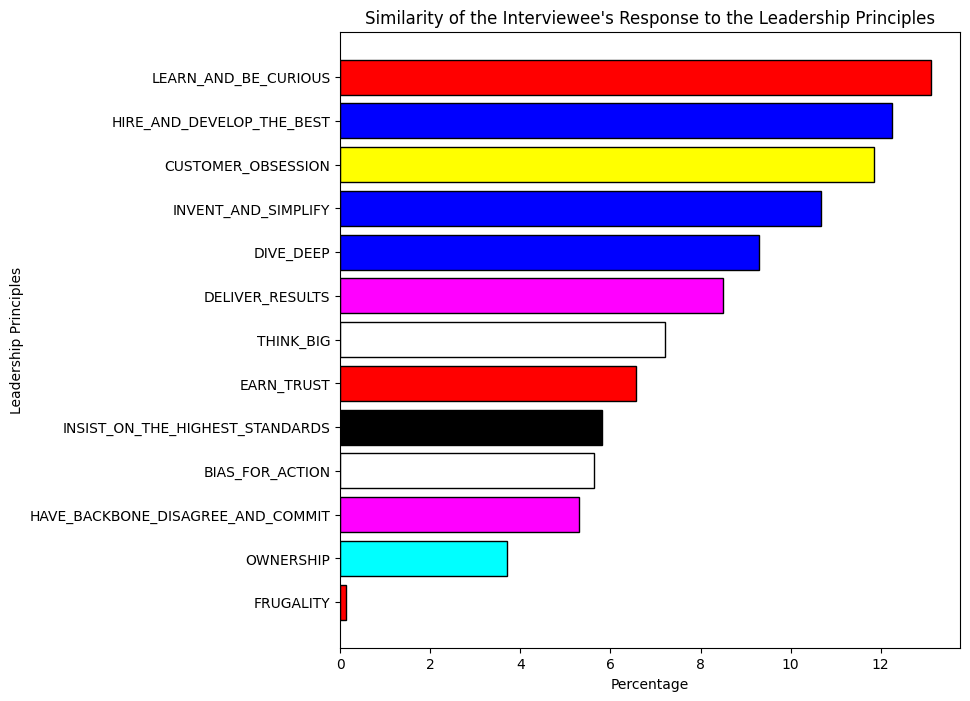

In [27]:
plot_horizontal_bar_chart(sorted_candidate_response_similarity_to_leadership_principles)

### POC GUI design using Gradio

In [28]:
import gradio as gr

with gr.Blocks() as coach_gpt_gradio_ui:
    gr.Markdown(
    """
    # Welcome to the AI Behavioral Interviewer for Software Engineers, Managers and Product engineers 🎤
    
    ## 📝 Instructions :

    1) Click on the button "Generate Random Question" to generate a random question.
    2) Click on the button "Evaluate By AI Interviewer" to evaluate the candidate response.
    
    ## 📊 AI Analysis Inerpretation :
    
    The evaluation result will be displayed in the text box "General Evaluation" and "Details Considering Different 
    Leadership Principles". The decomposed response to leadership principles will be displayed in the image part using cosine 
    similarity for more insigths. It gives you a sense of how the candidate response is related/ranked to different leadership 
    principles. 
    
    """)
    with gr.Column():
        btn_random_question = gr.Button("Generate Random Question")
        random_question = gr.Textbox(label="Behavioral Interview Question", )
        candidate_response = gr.Textbox(label="Candidate Response", lines=15)
        evaluate_by_ai = gr.Button("Evaluate By AI Interviewer")
        ai_evaluation = gr.Textbox(label= 'General Evaluation', lines=15)
        ai_detailed_evaluation = gr.Textbox(label= 'Details Considering Different Leadership Principles', lines=15)
        ai_similarity_analysis= gr.Plot(label="Decompisition your response to leadership principles using cosine similarity", type = "numpy")

        def generate_random_question():
            return interview_question

        btn_random_question.click(fn=generate_random_question, 
                                  outputs=[random_question], 
                                  api_name="generate_random_question")

        def evaluate_by_ai_interviewer(random_question, candidate_response):
            return {candidate_response:'hello world', 
                    ai_evaluation:'sdfhsdghsdgh',
                    ai_detailed_evaluation:'gcfhfdfd',
                    ai_similarity_analysis: graph_numpy}

        evaluate_by_ai.click(fn=evaluate_by_ai_interviewer, 
                  inputs=[random_question, candidate_response], 
                  outputs = [ai_evaluation, ai_detailed_evaluation, ai_similarity_analysis, ai_similarity_analysis], 
                  api_name="evaluate_by_ai_interviewer")

coach_gpt_gradio_ui.launch(width=600, 
                           height=400)



/var/folders/yz/9tg9c0h12kzc99h6142015hr0000gn/T/ipykernel_3563/3887657579.py:28: GradioUnusedKwargWarning: You have unused kwarg parameters in Plot, please remove them: {'type': 'numpy'}
  ai_similarity_analysis= gr.Plot(label="Decompisition your response to leadership principles using cosine similarity", type = "numpy")


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
